# Natural Language Processing

## Inhalt ##

1. Textdaten ermitteln<br>
2. Wordvektoren aus Textdaten
    2.1 Tfidf Vectoren<br> 
    2.2 Spacy Wordvektoren basierend auf der Deutschensprache<br>
3. Clustering mit Wortvektoren<br> 
    3.1 Dimensionsreduzierung der Wordvektoren<br> 
    3.2 Erstellen von Cluster ausschließlich mit den reduzierten Wordvektoren<br>
    3.3 Vergleich mit Clustern aus der Cluster Analyse<br> 

In [1]:
%store -r columns_encoded
%store -r columns
%store -r data
%store -r data_encoded

%store -r df_genres
%store -r data_original_reduced_tsne_hc

columns_encoded = columns_encoded
columns = columns
data = data
data_encoded = data_encoded

df_genres = df_genres
data_original_reduced_tsne_hc = data_original_reduced_tsne_hc

In [2]:
#!python -m spacy download de_core_news_md

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import spacy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

import plotly.express as px

pd.set_option('display.max_columns', None)

# 1. Textdaten ermitteln
Alle Textdaten, die aus dem Fragebogen hervorgehen werden in einem sepraten DataFrame gespeichert um im weiteren mit diesen eine NLP Analyse durchzuführen.

In [4]:
text_data_lieblingssportart = data[columns.lieblingssportart]
text_data_lieblingsessen = data[columns.lieblingsessen]
text_data_lieblingsgenre = df_genres
text_data_combined = text_data_lieblingssportart + " " + text_data_lieblingsessen + " " + df_genres

In [5]:
data_frame_content = {
    "lieblingssportart": text_data_lieblingssportart,
    "lieblingsessen": text_data_lieblingsessen,
    "lieblingsgenre": text_data_lieblingsgenre,
    "combined": text_data_combined
}

text_data = pd.DataFrame(data_frame_content)

text_data.head(10)


,lieblingssportart,lieblingsessen,lieblingsgenre,combined
0,Joggen,Vegane Lasagne,Rock,Joggen Vegane Lasagne Rock
1,Fußball,Butterbrot,Rock,Fußball Butterbrot Rock
2,Keine Lieblingssportart,Lasagne,Alternative,Keine Lieblingssportart Lasagne Alternative
3,Trampolin,Burger,Kein Lieblingsgenre,Trampolin Burger Kein Lieblingsgenre
4,Klettern,Dampfnudeln,Kein Lieblingsgenre,Klettern Dampfnudeln Kein Lieblingsgenre
5,Bouldern,Pho,Kein Lieblingsgenre,Bouldern Pho Kein Lieblingsgenre
6,Keine Lieblingssportart,Tomaten,Pop,Keine Lieblingssportart Tomaten Pop
7,Fußball,Pasta,Alternative,Fußball Pasta Alternative
8,Schnorcheln,Pizza,Rap/Hip Hop,Schnorcheln Pizza Rap/Hip Hop
9,Tennis,Sushi,Alternative,Tennis Sushi Alternative


# 2. Wordvektoren aus Textdaten

## 2.1 Tfidf Vectoren

In [6]:
tfidf_lieblingssportart = TfidfVectorizer(max_df=0.25, min_df=1)
tfidf_vectors_lieblingssportart = tfidf_lieblingssportart.fit_transform(text_data.lieblingssportart)
tfidf_lieblingssportart.get_feature_names_out()

array(['badminton', 'basketball', 'bogenschießen', 'bouldern',
       'calisthenics', 'fahren', 'fitness', 'football', 'fußball',
       'hockey', 'inlineskaten', 'joggen', 'kampfsport', 'karate',
       'keine', 'klettern', 'kraftsport', 'lieblingssportart', 'padel',
       'radfahren', 'reiten', 'ruderboot', 'schnorcheln', 'schwimmen',
       'ski', 'sport', 'squash', 'tanzen', 'tauchen', 'tennis',
       'thaiboxen', 'tischtennis', 'trampolin', 'volleyball', 'yoga'],
      dtype=object)

In [7]:
tfidf_lieblingsessen = TfidfVectorizer(max_df=0.25, min_df=1)
tfidf_vectors_lieblingsessen = tfidf_lieblingsessen.fit_transform(text_data.lieblingsessen)
tfidf_lieblingsessen.get_feature_names_out()

array(['asiatische', 'bleu', 'bo', 'bratkartoffeln', 'burger', 'burrito',
       'butterbrot', 'carbonara', 'cordon', 'curry', 'dakgangjeong',
       'dampfnudeln', 'döner', 'gemüse', 'gemüsepfanne', 'gurke',
       'gurkensalat', 'humus', 'hähnchen', 'hühnchen', 'in', 'kein',
       'koreanisches', 'lachs', 'lasagne', 'lieblingsessen', 'mit',
       'mozzarella', 'nudeln', 'ofenkartoffeln', 'pasta', 'pfannkuchen',
       'pho', 'pilzen', 'pizza', 'pommes', 'ramen', 'reis', 'reispfanne',
       'risotto', 'sahnesauce', 'shakshuka', 'sojasoße', 'suppe', 'sushi',
       'tofu', 'tomaten', 'tortelini', 'und', 'vegane', 'viel', 'yaprak'],
      dtype=object)

In [8]:
tfidf_lieblingsgenre = TfidfVectorizer(max_df=0.25, min_df=1)
tfidf_vectors_lieblingsgenre = tfidf_lieblingsgenre.fit_transform(text_data.lieblingsgenre)
tfidf_lieblingsgenre.get_feature_names_out()

array(['alternative', 'electro', 'filme', 'heavy', 'kein', 'klassik',
       'lieblingsgenre', 'metal', 'pop', 'rock', 'videospiele'],
      dtype=object)

Die TF-IDF Vektoren sind für die Weiter Clustern der Daten aber eher nicht zu benutzen, da dafür zu wenig und maxmimal 3 Wort Textdaten vorliegen. Man könnte die TF-IDF Vektoren aber nutzen, um die Antworten zu filtern und die wenigsten oder auch meist geschriebenen Antworten herauszufiltern.

## 2.2 Spacy Wordvektoren basierend auf der Deutschensprache
Im Folgenden werden alle Wortvektoren von allen Freitext-Fragen mit Hilfe des deutschen Datensatz von Spacy ermittelt und dem DataFrame angefügt. Diese werden dann genutzt um die Daten zu Clustern. 

In [9]:
nlp = spacy.load("de_core_news_md")

In [10]:
tokens_lieblingsportart = []
for entry in text_data.lieblingssportart:
    tokens_lieblingsportart.append(nlp(entry))
text_data["tokens_lieblingssportart"] = tokens_lieblingsportart

In [11]:
tokens_lieblingsessen = []
for entry in text_data.lieblingsessen:
    tokens_lieblingsessen.append(nlp(entry))
text_data["tokens_lieblingsessen"] = tokens_lieblingsessen

In [12]:
tokens_lieblingsgenre = []
for entry in text_data.lieblingsgenre:
    tokens_lieblingsgenre.append(nlp(entry))
text_data["tokens_lieblingsgenre"] = tokens_lieblingsgenre

In [13]:
tokens_combined = []
for entry in text_data.combined:
    tokens_combined.append(nlp(entry))
text_data["tokens_combined"] = tokens_combined

In [14]:
text_data.head(10)

,lieblingssportart,lieblingsessen,lieblingsgenre,combined,tokens_lieblingssportart,tokens_lieblingsessen,tokens_lieblingsgenre,tokens_combined
0,Joggen,Vegane Lasagne,Rock,Joggen Vegane Lasagne Rock,(Joggen),"(Vegane, Lasagne)",(Rock),"(Joggen, Vegane, Lasagne, Rock)"
1,Fußball,Butterbrot,Rock,Fußball Butterbrot Rock,(Fußball),(Butterbrot),(Rock),"(Fußball, Butterbrot, Rock)"
2,Keine Lieblingssportart,Lasagne,Alternative,Keine Lieblingssportart Lasagne Alternative,"(Keine, Lieblingssportart)",(Lasagne),(Alternative),"(Keine, Lieblingssportart, Lasagne, Alternative)"
3,Trampolin,Burger,Kein Lieblingsgenre,Trampolin Burger Kein Lieblingsgenre,(Trampolin),(Burger),"(Kein, Lieblingsgenre)","(Trampolin, Burger, Kein, Lieblingsgenre)"
4,Klettern,Dampfnudeln,Kein Lieblingsgenre,Klettern Dampfnudeln Kein Lieblingsgenre,(Klettern),(Dampfnudeln),"(Kein, Lieblingsgenre)","(Klettern, Dampfnudeln, Kein, Lieblingsgenre)"
5,Bouldern,Pho,Kein Lieblingsgenre,Bouldern Pho Kein Lieblingsgenre,(Bouldern),(Pho),"(Kein, Lieblingsgenre)","(Bouldern, Pho, Kein, Lieblingsgenre)"
6,Keine Lieblingssportart,Tomaten,Pop,Keine Lieblingssportart Tomaten Pop,"(Keine, Lieblingssportart)",(Tomaten),(Pop),"(Keine, Lieblingssportart, Tomaten, Pop)"
7,Fußball,Pasta,Alternative,Fußball Pasta Alternative,(Fußball),(Pasta),(Alternative),"(Fußball, Pasta, Alternative)"
8,Schnorcheln,Pizza,Rap/Hip Hop,Schnorcheln Pizza Rap/Hip Hop,(Schnorcheln),(Pizza),"(Rap, /, Hip, Hop)","(Schnorcheln, Pizza, Rap, /, Hip, Hop)"
9,Tennis,Sushi,Alternative,Tennis Sushi Alternative,(Tennis),(Sushi),(Alternative),"(Tennis, Sushi, Alternative)"


# 3. Clustering mit Wortvektoren
In diesem Abschnitt werden die vorher ermittelten Wordvektoren genutzt, um die Daten zu Clustern.

## 3.1 Dimensionsreduzierung der Wordvektoren
Um die Daten clustern zu können, müssen die Wordvektoren erst auf zwei Dimensionen reduziert werden. Dafür wird der TSNE Algorithmus genutzt.

In [15]:
tsne = TSNE(random_state=42)
lieblingssportart_vectors = np.array([token.vector for token in text_data.tokens_lieblingssportart])

tsne_vectors_lieblingssportart = tsne.fit_transform(lieblingssportart_vectors)

In [16]:
lieblingsessen_vectors = np.array([token.vector for token in text_data.tokens_lieblingsessen])
tsne_vectors_lieblingsessen = tsne.fit_transform(lieblingsessen_vectors)

In [17]:
lieblingsgenre_vectors = np.array([token.vector for token in text_data.tokens_lieblingsgenre])
tsne_vectors_lieblingsgenre = tsne.fit_transform(lieblingsgenre_vectors)

In [18]:
tsne_vectors = { 
    'x_coord_lieblingssportart' : tsne_vectors_lieblingssportart[:, 0], 
    'y_coord_lieblingssportart' : tsne_vectors_lieblingssportart[:, 1],
    'x_coord_lieblingsessen' : tsne_vectors_lieblingsessen[:, 0], 
    'y_coord_lieblingsessen' : tsne_vectors_lieblingsessen[:, 1],
    'x_coord_lieblingsgenre' : tsne_vectors_lieblingsgenre[:, 0], 
    'y_coord_lieblingsgenre' : tsne_vectors_lieblingsgenre[:, 1]
}

tsne_df = pd.DataFrame(tsne_vectors)

## 3.2 Erstellen von Cluster ausschließlich mit den reduzierten Wordvektoren
Die nun reduzierten Wordvektoren, der einzelnen Freitext-Fragen, werden nun von uns genutzt zum Clustern. Wir machen dafür eine herachisches Clustering zu 3 Clustern, genau wie im Clustering Teil.

In [19]:
ward = AgglomerativeClustering(linkage="ward",
                               n_clusters=3)

ward.fit(tsne_df)

# Cluster-Zentren
text_data["cluster"] = ward.labels_
text_data.head()

,lieblingssportart,lieblingsessen,lieblingsgenre,combined,tokens_lieblingssportart,tokens_lieblingsessen,tokens_lieblingsgenre,tokens_combined,cluster
0,Joggen,Vegane Lasagne,Rock,Joggen Vegane Lasagne Rock,(Joggen),"(Vegane, Lasagne)",(Rock),"(Joggen, Vegane, Lasagne, Rock)",1
1,Fußball,Butterbrot,Rock,Fußball Butterbrot Rock,(Fußball),(Butterbrot),(Rock),"(Fußball, Butterbrot, Rock)",0
2,Keine Lieblingssportart,Lasagne,Alternative,Keine Lieblingssportart Lasagne Alternative,"(Keine, Lieblingssportart)",(Lasagne),(Alternative),"(Keine, Lieblingssportart, Lasagne, Alternative)",0
3,Trampolin,Burger,Kein Lieblingsgenre,Trampolin Burger Kein Lieblingsgenre,(Trampolin),(Burger),"(Kein, Lieblingsgenre)","(Trampolin, Burger, Kein, Lieblingsgenre)",1
4,Klettern,Dampfnudeln,Kein Lieblingsgenre,Klettern Dampfnudeln Kein Lieblingsgenre,(Klettern),(Dampfnudeln),"(Kein, Lieblingsgenre)","(Klettern, Dampfnudeln, Kein, Lieblingsgenre)",0


In [20]:
#!pip install plotly

In [21]:
combined_vectors = np.array([token.vector for token in text_data.tokens_combined])
tsne_vectors_combined = tsne.fit_transform(combined_vectors)
text_data["x_coord"] = tsne_vectors_combined[:, 0]
text_data["y_coord"] = tsne_vectors_combined[:, 1]

In [22]:
df = px.data.iris()

features = df.loc[:, :'petal_width']

fig = px.scatter(
    text_data, x="x_coord", y="y_coord",
    color=text_data.cluster, labels={'color': 'species'},
    hover_data=["lieblingssportart", "lieblingsessen", "lieblingsgenre"]
)
fig.show()

**Ergebnis:** <br>
Es lassen sich gewisse Tendenzen in den Clustern erkennen. Es gibt aber keine wirklich eindutige Abgrenzungen zwischen den Clustern. Nur das Lieblingsgenre der Proband\*innen ist recht gut in den Clustern einzuordnen. Die anderen Antworten zeigen zwar einen näheren Abstand in den Clustern, falls mehrere Antworten übereinstimmen. Proband\*innen mit keinem Lieblingsgenre werden aber nicht ganz eindutig einem Cluster zu geordnet.

*Cluster 0:* <br>
In Cluster 0 haben die Proband\*innen als Lieblingsgenre Rap/Hip-Hop bis auf einen Ausreißer, welcher auch dem Cluster zu geordnet worden ist.

*Cluster 1:* <br>
Die Proband\*innen in Cluster 1 haben entweder das Lieblingsgenre Rock (linke Punkte des Clusters) oder Elektro (rechte Punkte des Clusters). Es gibt auch einige Punkte, die kein Lieblingsgenre angegeben haben. 

*Cluster 2:* <br>
Die Proband\*innen in Cluster 2 haben entweder das Lieblingsgenre Pop (linke Punkte des Clusters) oder Alternative (rechte Punkte des Clusters). Es gibt auch einige Punkte, die kein Lieblingsgenre angegeben haben. Dem Cluster wurden zudem die Genres zugeordnet R&B und Klassik zugeordnet. Dieses haben aber nur jeweils 1 Proband\*in angegeben. 

Genrell ist es schwer Gemeinsamkeiten zu erkennen und es gibt auch immer einzelne Datenpunkte die nicht dem vermutlich "richtigem" Cluster zugeordnet worden sind.

## 3.3 Vergleich mit Clustern aus der Cluster Analyse
Im folgenden werden wir die Cluster aus dem Cluster Analyse Teil mit den aus dem NLP vergeleichen. Dafür werden wir den Graphen nochmal zeichnen nur wir verwenden die Cluster aus der Cluster Analyse als Farbe, um so zusehen ob sich die Cluster ähneln oder unterschiede aufzeigen.

In [23]:
df = px.data.iris()

features = df.loc[:, :'petal_width']

fig = px.scatter(
    text_data, x="x_coord", y="y_coord",
    color=data_original_reduced_tsne_hc.Cluster, labels={'color': 'species'},
    hover_data=["lieblingssportart", "lieblingsessen", "lieblingsgenre"]
)
fig.show()

<Axes: title={'center': 'NLP Clustering mit Darstellung über die t-SNE-Reduktion der Cluster Analyse'}, xlabel='Hyperparameter1', ylabel='Hyperparameter2'>

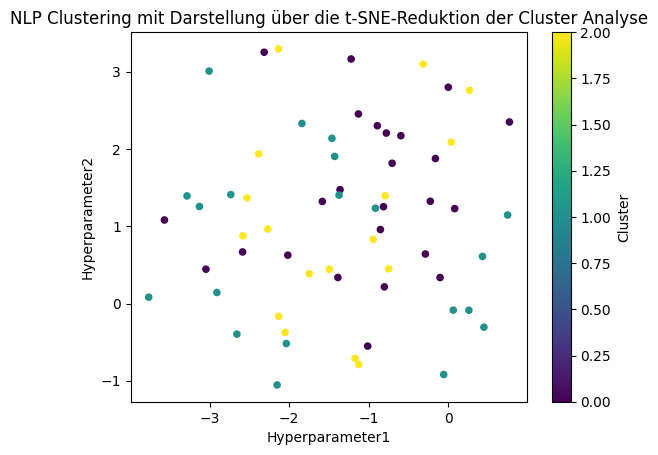

In [24]:
cluster_analysis_result = data_original_reduced_tsne_hc
cluster_analysis_result.Cluster = text_data.cluster

cluster_analysis_result.plot.scatter(x="Hyperparameter1", y="Hyperparameter2", c="Cluster", title="NLP Clustering mit Darstellung über die t-SNE-Reduktion der Cluster Analyse", cmap="viridis")

**Vergleich der Cluster:** <br>
Die Cluster aus der Cluster Analyse sind sehr verschieden zu den Cluster, die aus den Wortvektoren gebildet worden sind. Es sind somit keine Zusammenhänge zwischen den Freitext-Fragen und dem Rest zu erkennen. Dies entspricht auch den Erwartungen, da auch keine Korrelation zwischen den Fragen zu erkennen war.